# Setup MLFLOW for Experiment Tracking

In [1]:
#Setup MLflow for Data Tracking
#!pip install mlflow
#for MLFlow System Metric Tracking
#!pip install psutil pynvml

# Start the MLflow server
# mlflow server --host 127.0.0.1 --port 8080

import mlflow

mlflow.set_tracking_uri(uri="http://localhost:8080")

# set the experiment id
mlflow.set_experiment("Birds Classification")

<Experiment: artifact_location='mlflow-artifacts:/103112961041507576', creation_time=1712381623666, experiment_id='103112961041507576', last_update_time=1712381623666, lifecycle_stage='active', name='Birds Classification', tags={}>

## 1. Download Data:

BIRDS 525 SPECIES- IMAGE CLASSIFICATION  
525 species, 84635 train, 2625 test, 2625 validation images 224X224X3 jpg  

https://www.kaggle.com/datasets/gpiosenka/100-bird-species?resource=download  

Save archive.zip file into data/ folder

## 2. Unzip Data:  

In [2]:
import zipfile

#zipfile.ZipFile('data/archive.zip', 'r').extractall('data/')

## 3. Load Data

In [3]:
import torch
from torch import nn
import torchvision
from torchvision import transforms

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### 3.1 Set Datapath

In [4]:
from pathlib import Path
data_path = Path('data/')

train_path = data_path / 'train'
test_path = data_path / 'test'
valid_path = data_path / 'valid'

### 3.2 Visualize an image

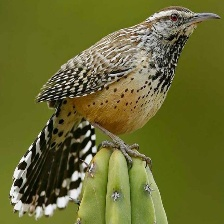

In [5]:
import random
from PIL import Image

image_path_list = list(data_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)

# Turn the image into an array
img = Image.open(random_image_path)
img

### 3.3 Get the transform for Image-Modifikation from the weights of the pertrained Model

Before using the pre-trained models, one must preprocess the image (resize with right resolution/interpolation, apply inference transforms, rescale the values etc). There is no standard way to do this as it depends on how a given model was trained. It can vary across model families, variants or even weight versions. Using the correct preprocessing method is critical and failing to do so may lead to decreased accuracy or incorrect outputs.

All the necessary information for the inference transforms of each pre-trained model is provided on its weights documentation. To simplify inference, TorchVision bundles the necessary preprocessing transforms into each model weight. These are accessible via the weight.transforms attribute:

In [6]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

### 3.4 Create Datasets with ImageFolder

In [7]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_path, # target folder of images
                                  transform=auto_transforms, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_path, 
                                 transform=auto_transforms)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 84635
    Root location: data/train
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 2625
    Root location: data/test
    StandardTransform
Transform: ImageClassification(
               crop_size=[224]
               resize_size=[256]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )


In [8]:
# Get class names as a list
class_names = train_data.classes

# Get number of classes
len(class_names)

525

In [9]:
# Check the lengths
len(train_data), len(test_data)

(84635, 2625)

In [10]:
# Get the first image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[ 1.7180,  1.7009,  1.6838,  ...,  2.1633,  2.1804,  2.1290],
         [ 1.7180,  1.7009,  1.7009,  ...,  2.1804,  2.1290,  2.0605],
         [ 1.7352,  1.7352,  1.7352,  ...,  2.1633,  2.0605,  2.0092],
         ...,
         [ 1.4269,  1.2728,  1.0502,  ..., -1.3473, -1.3302, -1.3644],
         [ 0.8789,  0.5707,  0.2967,  ..., -1.3302, -1.3302, -1.3644],
         [-0.1999, -0.1828, -0.0116,  ..., -1.3130, -1.3302, -1.4158]],

        [[ 1.7808,  1.7633,  1.7283,  ...,  2.1835,  2.2185,  2.1660],
         [ 1.7458,  1.7283,  1.7108,  ...,  2.2010,  2.1660,  2.1134],
         [ 1.7108,  1.7108,  1.6933,  ...,  2.2010,  2.1485,  2.1310],
         ...,
         [ 1.4482,  1.2906,  1.0805,  ..., -1.2129, -1.2304, -1.2654],
         [ 0.8004,  0.4678,  0.2227,  ..., -1.1954, -1.2129, -1.2479],
         [-0.3550, -0.3550, -0.1450,  ..., -1.2129, -1.2479, -1.3354]],

        [[ 1.7511,  1.7337,  1.7163,  ...,  2.2217,  2.2391,  2.1520],
         [ 1.7685,  1.7511,  1.

### 3.5 Turn loaded images into Dataloaders

In [11]:
# Batchsize
batch_size = 32

# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=batch_size, # how many samples per batch?
                              num_workers=4, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=batch_size, 
                             num_workers=4, 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f7b97e2a050>,
 <torch.utils.data.dataloader.DataLoader at 0x7f7b97e29270>)

### 3.5.1 View a DataLoader example for the first batch

In [12]:
for batch,(X,y) in enumerate(test_dataloader):
    print(f"Batch number: {batch}")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    print(f"y-Classes:")
    print(f"y: {y}")
    break

Batch number: 0
X shape: torch.Size([32, 3, 224, 224])
y shape: torch.Size([32])
y-Classes:
y: tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 5, 5, 5, 5, 5, 6, 6])


## 4. Getting a pretrained model

### 4.1 Setting up pretrained model

In [13]:
#Function for Model creation
def create_model(weights, class_names):
    
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)
    
    # Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
    for param in model.features.parameters():
        param.requires_grad = False
        
    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=0.2, inplace=True), 
        torch.nn.Linear(in_features=1280, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)).to(device)
    
    return model

# 5. Define Test//train Functions

In [14]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
  
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader and data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X, y = X.to(device), y.to(device) 

    # 1. Forward pass
    y_pred = model(X)
    # print(y_pred)

    # 2. Calculate and accumulate loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad 
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate and accumualte accuracy metric across all batches
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and average accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc 

 Erklärung:  
 y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)  

Die ausgewählte Zeile aus dem Python-Code führt eine Klassifikation auf den Vorhersagen `y_pred` eines Modells durch. Hier ist eine detaillierte Erklärung:

1. `torch.softmax(y_pred, dim=1)`: Die Softmax-Funktion wird auf `y_pred` angewendet. Softmax ist eine Funktion, die die Ausgaben eines Modells in Wahrscheinlichkeiten umwandelt, die sich zu 1 addieren. Der Parameter `dim=1` bedeutet, dass die Softmax-Funktion entlang der Spalten angewendet wird (d.h., für jede Zeile werden die Werte so skaliert, dass sie sich zu 1 addieren).

2. `torch.argmax(...)`: Die Funktion `argmax` gibt den Index des größten Wertes in einem Tensor zurück. In diesem Kontext wird es verwendet, um den Index der Klasse mit der höchsten Wahrscheinlichkeit zu bestimmen. Wiederum bedeutet `dim=1`, dass die Funktion entlang der Spalten angewendet wird (d.h., für jede Zeile wird der Index des größten Wertes zurückgegeben).

Zusammengefasst: Diese Zeile wandelt die Ausgaben des Modells in Wahrscheinlichkeiten um und wählt dann die Klasse mit der höchsten Wahrscheinlichkeit als Vorhersage für jede Eingabe aus.

In [15]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
  
  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)
      # print(test_pred_logits)

      # 2. Calculuate and accumulate loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate and accumulate accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
    
  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [16]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          learning_rate: float = 0.001):
    
    # Create results dictionary
    results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}
  

# Starten Sie ein neues MLflow Run
    with mlflow.start_run(log_system_metrics=True):
            # Protokollieren Sie Parameter
            mlflow.log_param("loss_fn", loss_fn)
            mlflow.log_param("optimizer", optimizer)
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("learning_rate", learning_rate)
        
            # Loop through the training and testing steps for a number of epochs
            for epoch in tqdm(range(epochs)):
                # Train step
                train_loss, train_acc = train_step(model=model, 
                                                dataloader=train_dataloader,
                                                loss_fn=loss_fn,
                                                optimizer=optimizer)
                # Test step
                test_loss, test_acc = test_step(model=model, 
                                                dataloader=test_dataloader,
                                                loss_fn=loss_fn)
                
                # Print out what's happening to mlfow
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metric("train_acc", train_acc, step=epoch)
                mlflow.log_metric("test_loss", test_loss, step=epoch)
                mlflow.log_metric("test_acc", test_acc, step=epoch)
                
                
                # Print out what's happening to the console
                print(f"Epoch: {epoch+1} | "
                    f"train_loss: {train_loss:.4f} | "
                    f"train_acc: {train_acc:.4f} | "
                    f"test_loss: {test_loss:.4f} | "
                    f"test_acc: {test_acc:.4f}"
                )

                # Update the results dictionary
                results["train_loss"].append(train_loss)
                results["train_acc"].append(train_acc)
                results["test_loss"].append(test_loss)
                results["test_acc"].append(test_acc)


    return results

## 5.1 Define Loss and Optimizer

In [17]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

## 5.2 Train Model

In [18]:
for learning_rate in [0.01, 0.001, 0.0001]:
    for epochs in [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
        print(f"------Lerning Rate: {learning_rate} -------Epochs: {epochs} -------------")
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        model_results = train(model=create_model(weights=weights, class_names=class_names),
                            train_dataloader=train_dataloader,
                            test_dataloader=test_dataloader,
                            optimizer=optimizer,
                            epochs=epochs,
                            learning_rate=learning_rate)


------Lerning Rate: 0.01 -------Epochs: 5 -------------


NameError: name 'model' is not defined